# Context: 

This dataset contains::
- Review ID
- rating out of 5
- comments by the rater.
- Disneyland location (it's all California)

The task is to create a sentiment analysis model that can classify the emotional sentiment of the review into positive and negative.

Plan of attack:
- Injest and process the data (remove missing values, etc.)
- Split data into train/test (90 - 10)
- Parse the data through an NLP model (tokenize, lemmatize, etc.)
- Vectorize this data
- Classify into positive and negative using appropriate classification models
- Evaluate against testing data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import sklearn
import spacy
import nltk

In [2]:
# data injestion
df = pd.read_csv('DisneylandReviews.csv')

# Explore the Data

In [3]:
#quick observation of data
df.head(5)

,Review_ID,Rating,Review_Text,Branch
0,670801367,5,This place has always been and forever will be...,Disneyland_California
1,670760708,5,A great day of simple fun and thrills. Bring c...,Disneyland_California
2,670565072,4,All and all a great day was had. The crowds ar...,Disneyland_California
3,670544335,5,Having been to the Florida location numerous t...,Disneyland_California
4,670472278,5,"Had the 4 day pass, spent 3 at DL and one at C...",Disneyland_California


In [4]:
df.dropna(how='any') #dropping any missing values row-wise

,Review_ID,Rating,Review_Text,Branch
0,670801367,5,This place has always been and forever will be...,Disneyland_California
1,670760708,5,A great day of simple fun and thrills. Bring c...,Disneyland_California
2,670565072,4,All and all a great day was had. The crowds ar...,Disneyland_California
3,670544335,5,Having been to the Florida location numerous t...,Disneyland_California
4,670472278,5,"Had the 4 day pass, spent 3 at DL and one at C...",Disneyland_California
...,...,...,...,...
19401,1563280,5,I have taken my music groups to Disneyland for...,Disneyland_California
19402,1540854,5,This is definitely the Happiest Place on Earth...,Disneyland_California
19403,1534364,1,"never again...what a horrible experience, the ...",Disneyland_California
19404,1506324,5,We take a long weekend trip to California each...,Disneyland_California


<Axes: title={'center': 'Number of Review by Ratings'}, xlabel='Rating'>

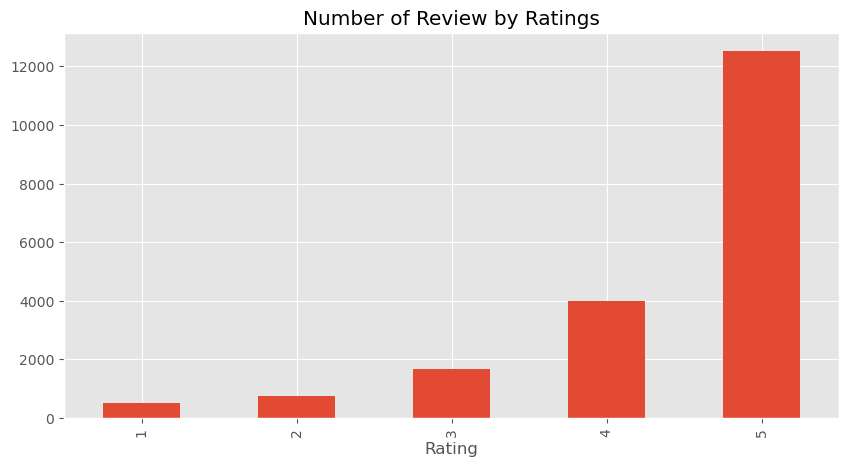

In [5]:
df['Rating'].value_counts().sort_index().plot(kind='bar', title='Number of Review by Ratings',
                                             figsize=(10,5))

# Initial NLTK

Doing some basic work with the NLTK on a random review to get the feel of it. 

In [6]:
example = df['Review_Text'][420]
print(example)

This park was hours of walking, but had a whole day of things to do! We enjoyed all of it. The only wish I wouldn't have done...wait 45 minutes for Peter Pan...I should have done the Winnie the Pooh ride 2x instead! Clean, Fun, and a full fun day experience!!


In [7]:
token_eg = nltk.word_tokenize(example)

In [8]:
tagged_eg = nltk.pos_tag(token_eg)
print(tagged_eg)

[('This', 'DT'), ('park', 'NN'), ('was', 'VBD'), ('hours', 'NNS'), ('of', 'IN'), ('walking', 'NN'), (',', ','), ('but', 'CC'), ('had', 'VBD'), ('a', 'DT'), ('whole', 'JJ'), ('day', 'NN'), ('of', 'IN'), ('things', 'NNS'), ('to', 'TO'), ('do', 'VB'), ('!', '.'), ('We', 'PRP'), ('enjoyed', 'VBD'), ('all', 'DT'), ('of', 'IN'), ('it', 'PRP'), ('.', '.'), ('The', 'DT'), ('only', 'JJ'), ('wish', 'NN'), ('I', 'PRP'), ('would', 'MD'), ("n't", 'RB'), ('have', 'VB'), ('done', 'VBN'), ('...', ':'), ('wait', 'VBP'), ('45', 'CD'), ('minutes', 'NNS'), ('for', 'IN'), ('Peter', 'NNP'), ('Pan', 'NNP'), ('...', ':'), ('I', 'PRP'), ('should', 'MD'), ('have', 'VB'), ('done', 'VBN'), ('the', 'DT'), ('Winnie', 'NNP'), ('the', 'DT'), ('Pooh', 'NNP'), ('ride', 'VBP'), ('2x', 'CD'), ('instead', 'RB'), ('!', '.'), ('Clean', 'NNP'), (',', ','), ('Fun', 'NNP'), (',', ','), ('and', 'CC'), ('a', 'DT'), ('full', 'JJ'), ('fun', 'NN'), ('day', 'NN'), ('experience', 'NN'), ('!', '.'), ('!', '.')]


In [9]:
entities_eg = nltk.chunk.ne_chunk(tagged_eg)
entities_eg.pprint()

(S
  This/DT
  park/NN
  was/VBD
  hours/NNS
  of/IN
  walking/NN
  ,/,
  but/CC
  had/VBD
  a/DT
  whole/JJ
  day/NN
  of/IN
  things/NNS
  to/TO
  do/VB
  !/.
  We/PRP
  enjoyed/VBD
  all/DT
  of/IN
  it/PRP
  ./.
  The/DT
  only/JJ
  wish/NN
  I/PRP
  would/MD
  n't/RB
  have/VB
  done/VBN
  .../:
  wait/VBP
  45/CD
  minutes/NNS
  for/IN
  (PERSON Peter/NNP Pan/NNP)
  .../:
  I/PRP
  should/MD
  have/VB
  done/VBN
  the/DT
  Winnie/NNP
  the/DT
  Pooh/NNP
  ride/VBP
  2x/CD
  instead/RB
  !/.
  (PERSON Clean/NNP)
  ,/,
  (PERSON Fun/NNP)
  ,/,
  and/CC
  a/DT
  full/JJ
  fun/NN
  day/NN
  experience/NN
  !/.
  !/.)


# Step 1. Valence Aware Dictionary and sEntiment Reasoner (VADER)

Using a bag of words approach to classify positive and negative sentiment.

This model will remove stopwords (i.e., filler words) as part of its process. 

In [10]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

In [11]:
sia = SentimentIntensityAnalyzer()

In [12]:
#poliarity score on the dataset
results = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Review_Text']
    myid = row['Review_ID']
    results[myid] = sia.polarity_scores(text)

  0%|          | 0/19406 [00:00<?, ?it/s]

In [13]:
vaders = pd.DataFrame.from_dict(results, orient='index')
vaders = pd.DataFrame(results).T
vaders = vaders.reset_index().rename(columns={'index':'Review_ID'})
vaders = vaders.merge(df,how='left',on='Review_ID')
# merging the vaders dataset with the df original dataset

In [14]:
vaders.head(3) #checking the merger was successful

,Review_ID,neg,neu,pos,compound,Rating,Review_Text,Branch
0,670801367,0.000,0.754,0.246,0.9008,5,This place has always been and forever will be...,Disneyland_California
1,670760708,0.000,0.741,0.259,0.9595,5,A great day of simple fun and thrills. Bring c...,Disneyland_California
2,670565072,0.087,0.729,0.184,0.7319,4,All and all a great day was had. The crowds ar...,Disneyland_California


### Plotting VADER Results

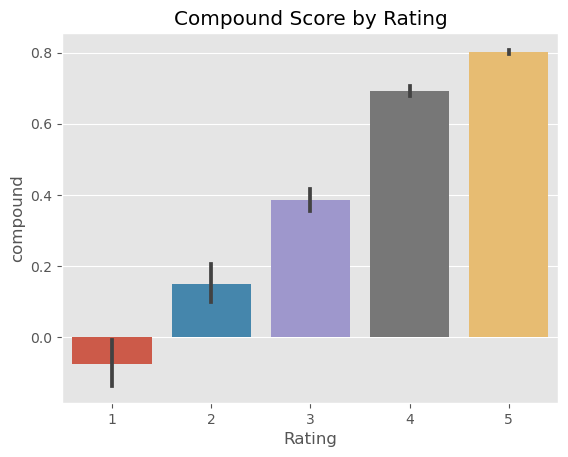

In [15]:
ax = sns.barplot(data=vaders, x='Rating', y='compound')
ax.set_title('Compound Score by Rating')
plt.show()

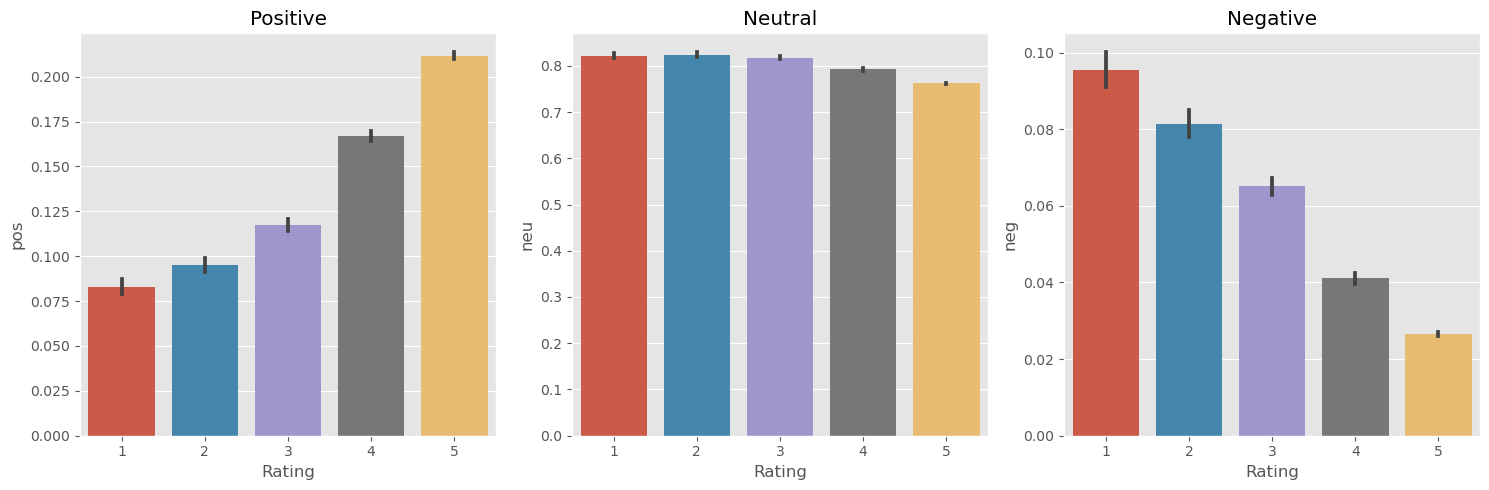

In [16]:
#make subplots side by side for comparison, by pos/neu/neg scores by Vader
fig, axs = plt.subplots(1, 3, figsize=(15,5))
sns.barplot(data=vaders, x='Rating', y='pos', ax = axs[0])
sns.barplot(data=vaders, x='Rating', y='neu', ax = axs[1])
sns.barplot(data=vaders, x='Rating', y='neg', ax = axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

These results are pretty much what we'd expect. Firstly, the positive VADER scores are most represented for the higher ratings out of 5. The negative VADER scores are most represented for the lower ratings. For neutral, it seems fairly even, except that 4 and 5 star ratings tend to have less neutrally-scored sentiment by VADERS. For neutral, this is neither here nor there, as neutral words aren't the most important. The most important insight we have here, is that there seems to be a strong correlation between positive/negative sentiment, and the ratings made by customers.

Same can be said for the compound scores. Negative compound sentiment scores are most prevalent at the lower ratings, the opposite being true for the higher ratings.

Overall, this confirms an initial inuititive hypothesis that ratings given by customers will have a strong correlation to the sentiment expressed in their written review.

# Robustly Optimized BERT Approach (RoBERTa) Pretrained Model

This is a pre-trained deep learning model.

This model uses transformers - which helps detect valance from the context of words. I.e., having certain words positioned in a sentence next to others, in certain orders, etc., that give it extra meaning. VADERS simply looked at each individual token (minus stopwords), categorised it as positive/neutral/negative, adds them up, then spits out a score. RoBERTa, on the other hand will look at tokens and their relative positioning within their sentence to give a more nuanced sentiment score.

In [17]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
import torch

In [18]:
#enabling CUDA to speed up the processing speeds - this checks to ensure there's a device capable
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [19]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
#loading the relevant models

In [20]:
model.to(device)
device
#enables CUDA for the model

device(type='cuda')

### Example and Brief Comparison

In [21]:
print(example) #a relatively positive example of text, to show how the two models work differently

This park was hours of walking, but had a whole day of things to do! We enjoyed all of it. The only wish I wouldn't have done...wait 45 minutes for Peter Pan...I should have done the Winnie the Pooh ride 2x instead! Clean, Fun, and a full fun day experience!!


In [22]:
encoded = tokenizer(example, return_tensors='pt')
encoded = {key: value.to(device) for key, value in encoded.items()} #example to show what the model is doing
with torch.no_grad():
    eg_output = model(**encoded)
scores = eg_output.logits[0].detach().cpu().numpy()
scores = softmax(scores)
scores

#scores from left to right are, negative, neutral, positive. Similar to the VADERS output but using the Roberta model.

array([0.0084276 , 0.03174039, 0.95983195], dtype=float32)

In [23]:
sia.polarity_scores(example) #this is using the VADERS model. 

{'neg': 0.0, 'neu': 0.66, 'pos': 0.34, 'compound': 0.9739}

The results on the example text from earlier show that the the neutral score has significantly decreased, while the positive score has significantly incerased moving from VADERS to Roberta.

A big reason for this is the increased contextual sensitivity. By looking at how the words relate within their sentences, a more nuanced score can be extracted.

However, interestingly, the compound score of VADERS is similar to the overall positive score of the Roberta model. This is because the VADERS model gives all its neutral score to the higher of the pos/neg, which is a very rough heuristic.

## Analysis of Review Text

Analysing review text with the RoBERTa model. 

In [24]:
def polarity_scores_roberta(text):
    encoded = tokenizer(text, return_tensors='pt', max_length=512, truncation=True)
    encoded = {key: value.to(device) for key, value in encoded.items()}
    with torch.no_grad():
        eg_output = model(**encoded)
    logits = eg_output.logits[0].detach().cpu().numpy()
    scores = softmax(logits)
    scores_dict = {
        'roberta_neg': scores[0],
        'roberta_neu': scores[1],
        'roberta_pos': scores[2]
    }
    return scores_dict

In [25]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Review_Text']
    myid = row['Review_ID']
    vader_result = sia.polarity_scores(text)
    vader_result_rename = {f"vader_{key}": value for key, value in vader_result.items()}
    roberta_result = polarity_scores_roberta(text)
    both = {**vader_result_rename, **roberta_result}
    res[myid] = both

  0%|          | 0/19406 [00:00<?, ?it/s]

In [26]:
res #see the results and ensure all the lines of the function have worked properly

{670801367: {'vader_neg': 0.0,
  'vader_neu': 0.754,
  'vader_pos': 0.246,
  'vader_compound': 0.9008,
  'roberta_neg': 0.001560148,
  'roberta_neu': 0.009007211,
  'roberta_pos': 0.98943263},
 670760708: {'vader_neg': 0.0,
  'vader_neu': 0.741,
  'vader_pos': 0.259,
  'vader_compound': 0.9595,
  'roberta_neg': 0.0016031032,
  'roberta_neu': 0.010467633,
  'roberta_pos': 0.9879292},
 670565072: {'vader_neg': 0.087,
  'vader_neu': 0.729,
  'vader_pos': 0.184,
  'vader_compound': 0.7319,
  'roberta_neg': 0.009501186,
  'roberta_neu': 0.053587765,
  'roberta_pos': 0.93691105},
 670544335: {'vader_neg': 0.072,
  'vader_neu': 0.78,
  'vader_pos': 0.148,
  'vader_compound': 0.9458,
  'roberta_neg': 0.0094135925,
  'roberta_neu': 0.043673318,
  'roberta_pos': 0.94691306},
 670472278: {'vader_neg': 0.075,
  'vader_neu': 0.821,
  'vader_pos': 0.104,
  'vader_compound': 0.0572,
  'roberta_neg': 0.0040909634,
  'roberta_neu': 0.039689627,
  'roberta_pos': 0.95621943},
 670382191: {'vader_neg': 0.

In [27]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Review_ID'})
results_df = results_df.merge(df, how='left')
#merging the results into a dataframe

In [28]:
results_df.head(3) #check that the merge worked, it did

,Review_ID,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,Rating,Review_Text,Branch
0,670801367,0.000,0.754,0.246,0.9008,0.001560,0.009007,0.989433,5,This place has always been and forever will be...,Disneyland_California
1,670760708,0.000,0.741,0.259,0.9595,0.001603,0.010468,0.987929,5,A great day of simple fun and thrills. Bring c...,Disneyland_California
2,670565072,0.087,0.729,0.184,0.7319,0.009501,0.053588,0.936911,4,All and all a great day was had. The crowds ar...,Disneyland_California


# VADER vs RoBERTa Comparison

In [29]:
results_df.columns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

<function matplotlib.pyplot.show(close=None, block=None)>

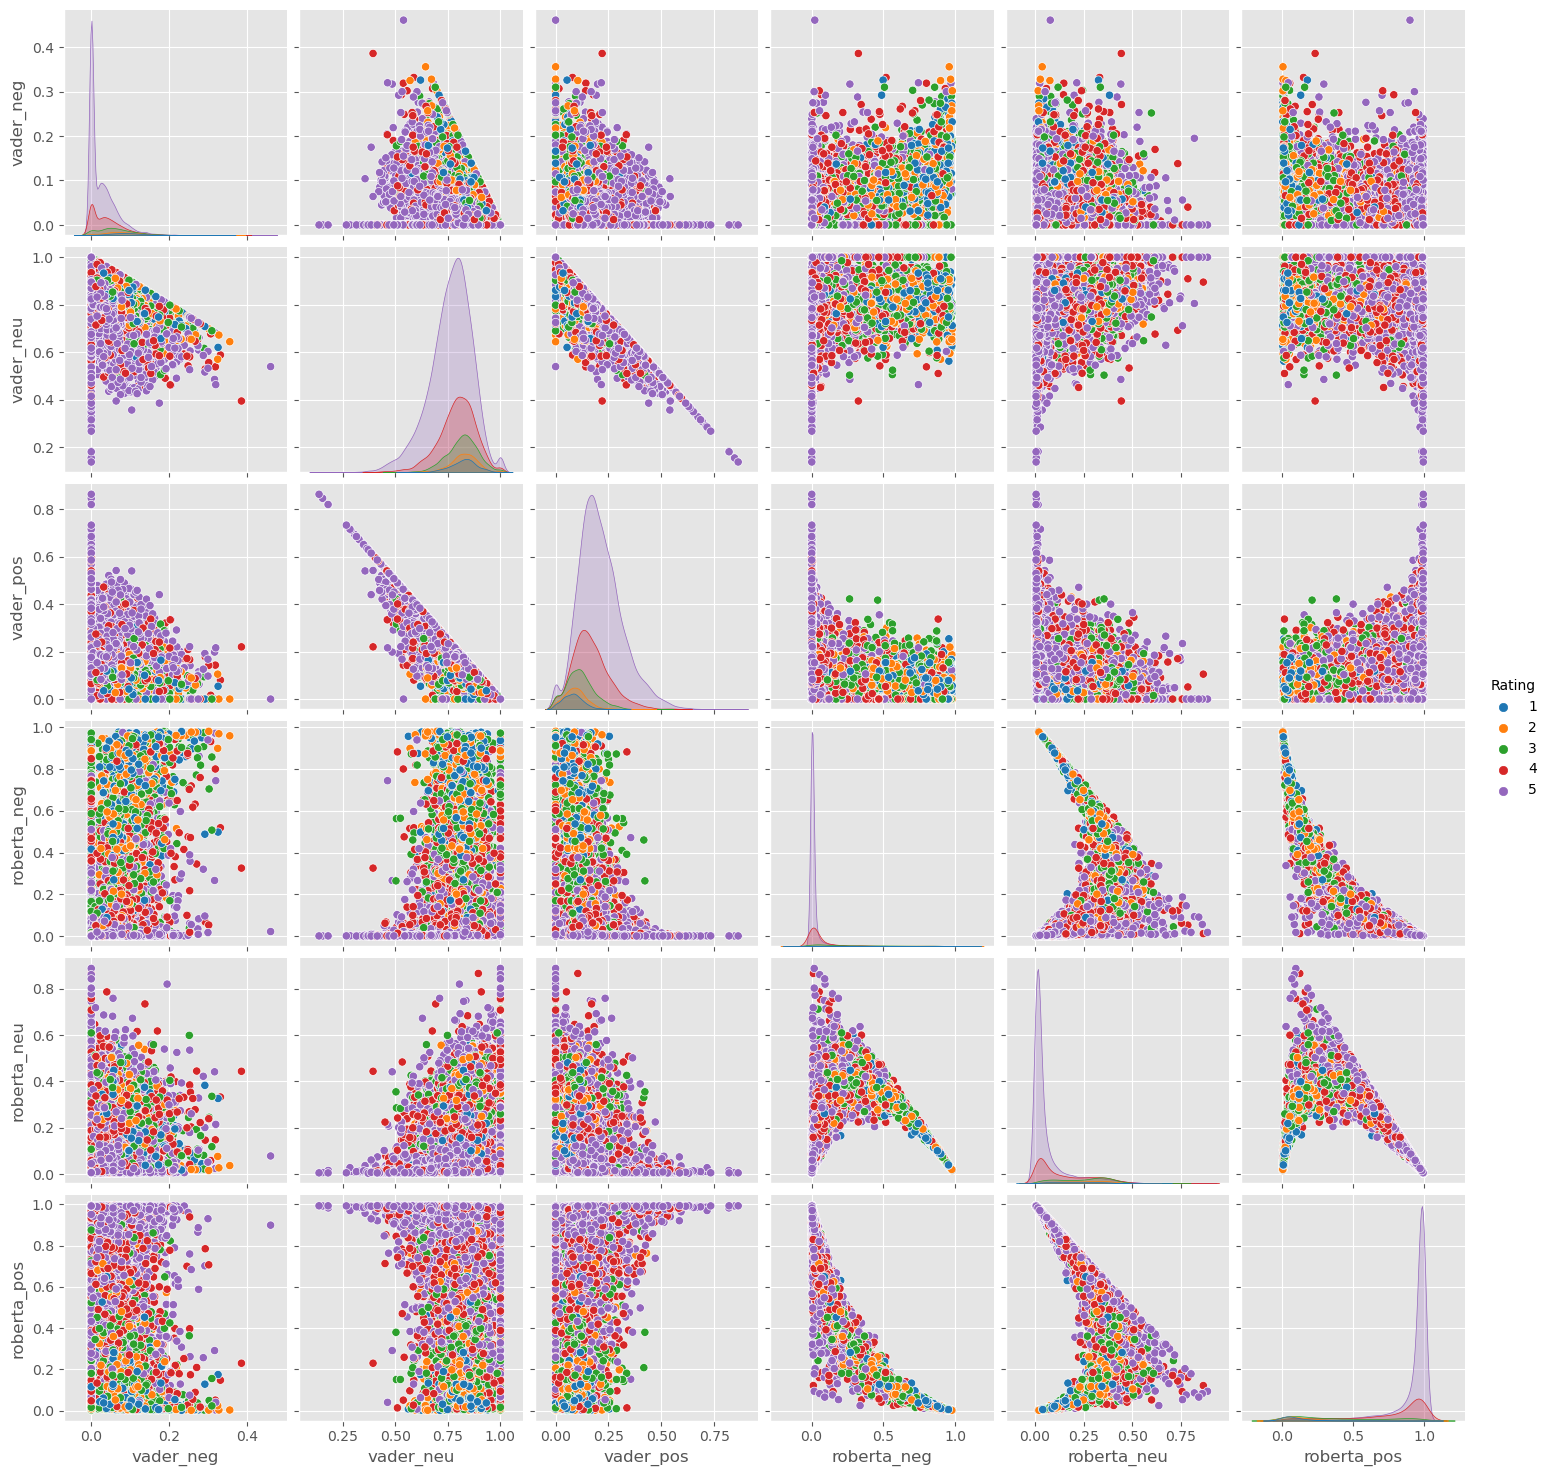

In [30]:
sns.pairplot(data=results_df, 
             vars = ['vader_neg', 'vader_neu', 'vader_pos',
                    'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Rating',
            palette='tab10')
plt.show

What are the graphs telling us?
- Observing the bell curves shows a tighter (leptokurtic) middle point on the RoBERTa model. This means that the model is more confident in clustering pos/neu/neg review sentiments based on their text. In comparison, the VADERS model shows a far wider (platykurtic) bell curve, which highlights a wider variance in the scores assigned to sentiment.
- The scatterplots are harder to interpret because it's a lot of data being squeezed into a smaller space. But it shows that there is a wider variance in how scores are assigned. Looking at neg and positive, where we should see more clustering of 1s and 5s, the VADERS model is not as tight compared to the RoBERTa model. 
- Overall, through eyeballing these charts, I can say that both the VADERS and RoBERTa model have an easier time classifying positive sentiment than negative sentiment - as observed by more purples (5s) being near the top of the chart in negative attributions compared to blues (1s) in the positive attributions.

## Visualise Sentiment Breakdown for Each Model

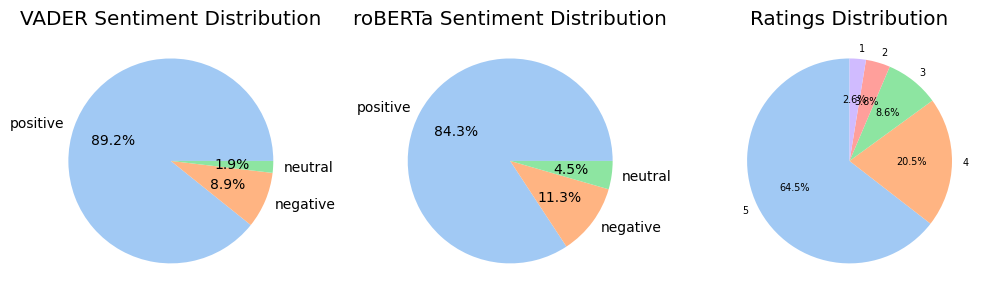

In [31]:
# categorise VADER sentiments based on compound score
results_df['vader_sentiment'] = results_df['vader_compound'].apply(lambda x: 'positive' if x > 0.05 else ('negative' if x < -0.05 else 'neutral'))

# categorise roBERTa sentiments based on scores
results_df['roberta_sentiment'] = results_df.apply(lambda x: 'positive' if x['roberta_pos'] > x['roberta_neg'] and x['roberta_pos'] > x['roberta_neu'] else ('negative' if x['roberta_neg'] > x['roberta_pos'] and x['roberta_neg'] > x['roberta_neu'] else 'neutral'), axis=1)

# percentages for VADER sentiments
vader_counts = results_df['vader_sentiment'].value_counts(normalize=True) * 100

# percentages for roBERTa sentiments
roberta_counts = results_df['roberta_sentiment'].value_counts(normalize=True) * 100

# plot VADER pie chart
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
vader_counts.plot.pie(autopct='%1.1f%%', colors=sns.color_palette("pastel"))
plt.title('VADER Sentiment Distribution')
plt.ylabel('')

# plot roBERTa pie chart
plt.subplot(1, 3, 2)
roberta_counts.plot.pie(autopct='%1.1f%%', colors=sns.color_palette("pastel"))
plt.title('roBERTa Sentiment Distribution')
plt.ylabel('')

rating_counts = results_df['Rating'].value_counts(normalize=True) * 100

# Plotting the ratings pie chart
plt.subplot(1, 3, 3)
rating_counts.plot.pie(autopct='%1.1f%%', colors=sns.color_palette("pastel"), startangle=90, fontsize=7)
plt.title('Ratings Distribution')
plt.ylabel('')

#show the pie charts
plt.tight_layout()
plt.show()

Fairly similar distributions for both models. Obviously, because roBERTa uses the stronger technology, it's probably more accurate.

The best way to compare their accuracy will be agains the ratings given (out of 5).

Let's say that positive will equal a 4 or 5 rating. Neutral will be a 3 rating. And 1 or 2 is a negative rating.

The most accurate model will have similar % distribution according to those numbers. And that seems to be the roBERTa model. 

Intereting points to note:
- both have underestimated the neutral sentiment based on ratings given; VADER moreso
- Both have overestimated the negative; roBERTa moreso
- VADER overestimated positive

Overall, it seems like VADER is much more sensitive to positive attributions, and seems to prefer to avoid neutral sentiment. This may be due to not looking at context. However, even roBERTa has underestimated neutral in favour of the negative. There's probably some nauance here. People can write long reviews, and it's difficult to give a precise overview of, let'say, a 300 word review where someone has expressed 3 - 4 sentiments across a number of themes. Something like Disneyworld has many parts - the rides, food, atmosphere, weather, locations, other guests, views, attractions, mascots, ticket prices, wait times, etc... Giving a single score to review which could look at these themes in different ways is not great. 

The value seems to be drilling into the data, say, pulling up a negative (1/2) rating, with a neutral or positive sentiment, and seeing what they're saying. 

# Phrase Count by Sentiment

The idea is now to get major topics by sentiment.

These are the criteria:
- roberta_pos > .5 AND rating > 3
- roberta_neg > .5 AND rating < 3

The idea is to create two dataframes, one holding the positive sentiments, one with negatives. 

Each of these dataframes will then have topics (~ 3 words) extracted, and these topics will have a summary next to them (~ 120 words)

Then create a topic network visual for those topics using networkx.

### Remove Irrelevant Columns and Remove Stopwords

In [32]:
import spacy
from collections import Counter
import string

In [33]:
#spacy.cli.download("en_core_web_lg")
nlp = spacy.load("en_core_web_lg")

In [34]:
neg_reviews = results_df[(results_df['roberta_neg'] > 0.5) & (results_df['Rating'] < 3)]
pos_reviews = results_df[(results_df['roberta_pos'] > 0.5) & (results_df['Rating'] > 3)]

neg_reviews.drop(['Review_ID', 'vader_neg', 
                           'vader_neu', 'vader_pos', 'vader_compound', 
                           'roberta_neg', 'roberta_neu', 'roberta_pos', 'Rating', 'Branch',
                 'vader_sentiment', 'roberta_sentiment'], axis=1)
pos_reviews.drop(['Review_ID', 'vader_neg', 
                           'vader_neu', 'vader_pos', 'vader_compound', 
                           'roberta_neg', 'roberta_neu', 'roberta_pos', 'Rating', 'Branch', 
                  'vader_sentiment', 'roberta_sentiment'], axis=1)

,Review_Text
0,This place has always been and forever will be...
1,A great day of simple fun and thrills. Bring c...
2,All and all a great day was had. The crowds ar...
3,Having been to the Florida location numerous t...
4,"Had the 4 day pass, spent 3 at DL and one at C..."
...,...
19400,We were at Disneyland September 8 12th. What a...
19401,I have taken my music groups to Disneyland for...
19402,This is definitely the Happiest Place on Earth...
19404,We take a long weekend trip to California each...


In [35]:
def remove_stopwords(text):
    doc = nlp(text)
    tokens = [
        token.text for token in doc
        if not token.is_stop and not token.is_punct and not token.is_space and len(token.text) > 3 and token.is_alpha
    ]
    return ' '.join(tokens)

In [36]:
neg_reviews = neg_reviews[["Review_Text"]].astype(str)
pos_reviews = pos_reviews[["Review_Text"]].astype(str)

In [37]:
pos_reviews['Review_Text'] = pos_reviews['Review_Text'].apply(remove_stopwords)
neg_reviews['Review_Text'] = neg_reviews['Review_Text'].apply(remove_stopwords)

### Parse, Tokenize, and Lemmatize

In [38]:
def process_column(data, col_to_parse):
    tokens = []
    lemmas = []
    pos = []
    parsed_doc = []
    
    for doc in nlp.pipe(data[col_to_parse].astype('unicode').values, batch_size=50):
        if doc.has_annotation('TAG'):
            parsed_doc.append(doc)
            tokens.append([token.text for token in doc])
            lemmas.append([token.lemma_ for token in doc])
            pos.append([token.pos_ for token in doc])
        else:
            tokens.append(None)
            lemmas.append(None)
            pos.append(None)
        
    return parsed_doc, tokens, lemmas, pos

In [39]:
pos_reviews['parsed'], pos_reviews['tokens'], pos_reviews['lemma'], pos_reviews['posn'] = process_column(pos_reviews, 'Review_Text')
neg_reviews['parsed'], neg_reviews['tokens'], neg_reviews['lemma'], neg_reviews['posn'] = process_column(neg_reviews, 'Review_Text')

In [40]:
pos_reviews.head(2) #check to make sure it was done

,Review_Text,parsed,tokens,lemma,posn
0,place forever special feeling entering park se...,"(place, forever, special, feeling, entering, p...","[place, forever, special, feeling, entering, p...","[place, forever, special, feeling, enter, park...","[VERB, ADV, ADJ, NOUN, VERB, NOUN, VERB, NOUN,..."
1,great simple thrills Bring cash cheap knew Dis...,"(great, simple, thrills, Bring, cash, cheap, k...","[great, simple, thrills, Bring, cash, cheap, k...","[great, simple, thrill, bring, cash, cheap, kn...","[ADJ, ADJ, NOUN, VERB, NOUN, ADJ, VERB, PROPN,..."


## Word Counter

In [41]:
def count_keywords(lemma_list):
    words = [lemma for sublist in lemma_list for lemma in sublist if lemma]
    word_freq = Counter(words)
    return word_freq

pos_keywords = count_keywords(pos_reviews['lemma'])
neg_keywords = count_keywords(neg_reviews['lemma'])

In [42]:
pos_keywords.most_common(20)

[('ride', 16441),
 ('park', 14613),
 ('time', 13481),
 ('Disneyland', 12630),
 ('Disney', 8431),
 ('great', 6667),
 ('line', 6038),
 ('visit', 5808),
 ('go', 5698),
 ('pass', 5389),
 ('place', 5315),
 ('love', 5264),
 ('wait', 5129),
 ('good', 5074),
 ('year', 4661),
 ('kid', 3952),
 ('like', 3909),
 ('long', 3817),
 ('enjoy', 3408),
 ('crowd', 3383)]

In [43]:
neg_keywords.most_common(20)

[('ride', 1324),
 ('park', 1228),
 ('line', 840),
 ('time', 793),
 ('Disneyland', 758),
 ('Disney', 723),
 ('wait', 655),
 ('people', 609),
 ('hour', 486),
 ('go', 473),
 ('crowd', 417),
 ('visit', 410),
 ('pass', 407),
 ('place', 401),
 ('long', 375),
 ('ticket', 343),
 ('like', 332),
 ('year', 330),
 ('minute', 325),
 ('money', 319)]

So this is very basic for now, but we can already see some themes by connecting the dots of the most commonly mentioned (lemmatized) words.

Let's visualise it for business use. Note: max_words should correspond to the words used in the most common earlier so that you're visualising that list. And relative_scaling = 1 will make sure the word size corresponds exactly to the proportion of its occurence in the list. 

In [44]:
from wordcloud import WordCloud

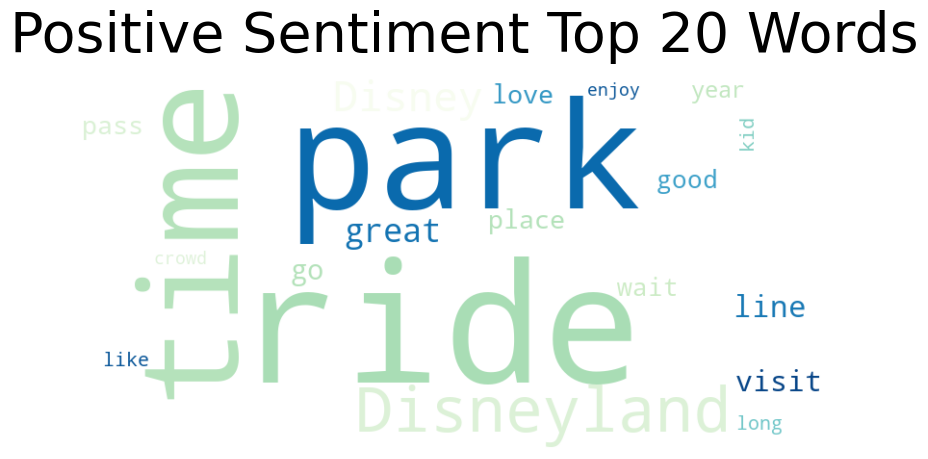

In [45]:
wordcloud = WordCloud(width=800, height=400, max_words = 20, relative_scaling = 1,
                      background_color='white', colormap = 'GnBu').generate_from_frequencies(pos_keywords)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Sentiment Top 20 Words', fontsize = 40)
plt.show()

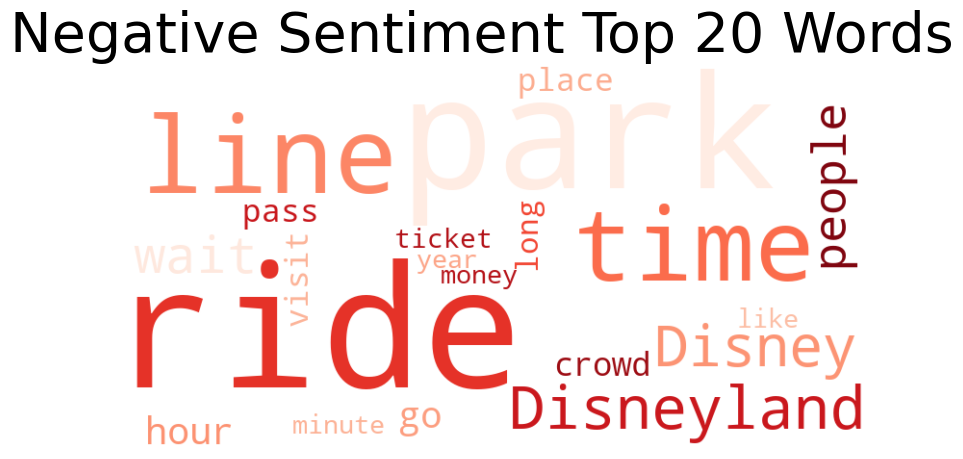

In [46]:
wordcloud = WordCloud(width=800, height=400, max_words = 20, relative_scaling = 1,
                      background_color='white', colormap = 'Reds').generate_from_frequencies(neg_keywords)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Sentiment Top 20 Words', fontsize = 40)
plt.show()

## Phrase Counting

In [47]:
from spacy.matcher import Matcher

In [48]:
matcher = Matcher(nlp.vocab)
noun_verb_pattern = [{'POS':'NOUN'}, {'POS':'VERB'}]
noun_verb_noun_pattern = [{'POS':'NOUN'}, {'POS':'VERB'}, {'POS':'NOUN'}]
noun_verb_adj_pattern = [{'POS':'NOUN'}, {'POS':'VERB'}, {'POS':'ADJ'}]
adj_noun_pattern = [{'POS':'ADJ'}, {'POS':'NOUN'}]
verb_adj_noun_pattern = [{'POS': 'VERB'}, {'POS': 'ADJ'}, {'POS': 'NOUN'}]
noun_clause_pattern = [{'POS': 'NOUN'}, {'ENT_TYPE': 'RELCL'}]
verb_object_pattern = [{'POS': 'VERB'}, {'DEP': 'dobj'}]
noun_prep_noun_pattern = [{'POS': 'NOUN'}, {'POS': 'ADP'}, {'POS': 'NOUN'}]
verb_noun_noun_pattern = [{'POS':'VERB'}, {'POS':'NOUN'}, {'POS':'NOUN'}]
adj_noun_verb_pattern = [{'POS':'ADJ'}, {'POS':'NOUN'}, {'POS':'VERB'}]

matcher.add("NOUN_VERB", [noun_verb_pattern])
matcher.add("NOUN_VERB_NOUN", [noun_verb_noun_pattern])
matcher.add("NOUN_VERB_ADJ", [noun_verb_adj_pattern])
matcher.add("ADJ_NOUN", [adj_noun_pattern])
matcher.add("VERB_ADJ_NOUN", [verb_adj_noun_pattern])
matcher.add("NOUN_CLAUSE", [noun_clause_pattern])
matcher.add("VERB_OBJECT", [verb_object_pattern])
matcher.add("NOUN_PREP_NOUN", [noun_prep_noun_pattern])
matcher.add("VERB_NOUN_NOUN", [verb_noun_noun_pattern])
matcher.add("ADJ_NOUN_VERB", [adj_noun_verb_pattern])

In [49]:
def extract_phrases(text):
    doc = nlp(text)
    matches = matcher(doc, as_spans=True)
    phrases = [span.text.lower() for span in matches]
    return phrases

def process_columns(data, col_to_parse):
    all_phrases = []
    for text in data[col_to_parse].dropna().astype('unicode').values:
        phrases = extract_phrases(text)
        all_phrases.extend(phrases)
    return Counter(all_phrases)

In [50]:
pos_phrase_freq = process_columns(pos_reviews, 'Review_Text')
neg_phrase_freq = process_columns(neg_reviews, 'Review_Text')

In [51]:
print("Most common phrases in positive reviews:")
print(pos_phrase_freq.most_common(20))

# Print most common phrases for negative reviews
print("\nMost common phrases in negative reviews:")
print(neg_phrase_freq.most_common(20))

Most common phrases in positive reviews:
[('great time', 1249), ('fast pass', 913), ('happiest place', 850), ('fast passes', 668), ('long lines', 583), ('popular rides', 454), ('great place', 370), ('magical place', 351), ('good time', 304), ('wonderful time', 256), ('single rider', 249), ('best time', 246), ('small world', 218), ('little ones', 217), ('great experience', 206), ('spent days', 187), ('great rides', 184), ('early morning', 182), ('annual pass', 174), ('cast members', 173)]

Most common phrases in negative reviews:
[('fast pass', 77), ('happiest place', 76), ('long lines', 61), ('rides closed', 59), ('fast passes', 34), ('lines rides', 34), ('park crowded', 27), ('annual pass', 23), ('minutes ride', 22), ('attractions closed', 21), ('cast members', 20), ('long line', 19), ('small children', 19), ('half hour', 18), ('long time', 18), ('good time', 17), ('rides broken', 16), ('park closed', 16), ('worth money', 15), ('spend money', 15)]


In [52]:
top_pos_phrases = [phrase[0] for phrase in pos_phrase_freq.most_common(20)]
top_neg_phrases = [phrase[0] for phrase in neg_phrase_freq.most_common(20)]

# Creating a DataFrame to store the top phrases
top_phrases_df = pd.DataFrame({
    'Top 20 POSITIVE Phrases': top_pos_phrases,
    'Top 20 NEGATIVE Phrases': top_neg_phrases
})

top_phrases_df

,Top 20 POSITIVE Phrases,Top 20 NEGATIVE Phrases
0,great time,fast pass
1,fast pass,happiest place
2,happiest place,long lines
3,fast passes,rides closed
4,long lines,fast passes
5,popular rides,lines rides
6,great place,park crowded
7,magical place,annual pass
8,good time,minutes ride
9,wonderful time,attractions closed


A list definitely helps, but let's also visualise these top phrases with similar word clouds. 

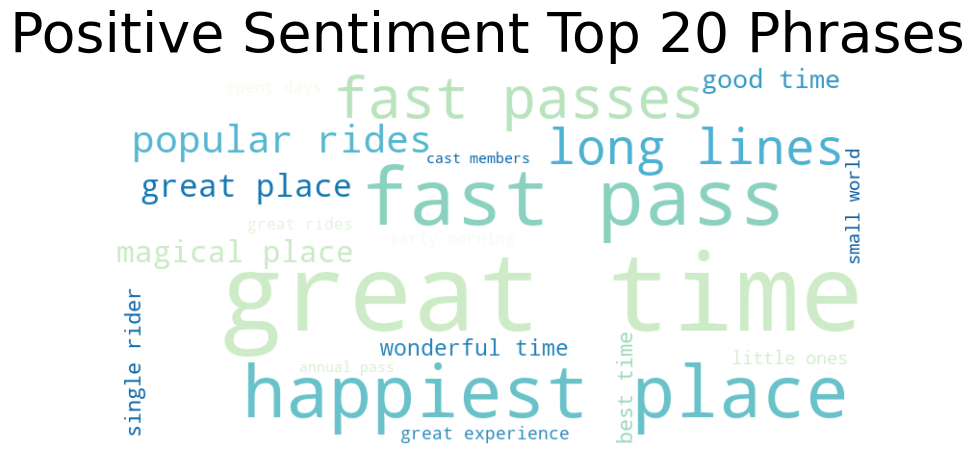

In [53]:
wordcloud = WordCloud(width=800, height=400, max_words = 20, relative_scaling = 1,
                      background_color='white', colormap = 'GnBu').generate_from_frequencies(pos_phrase_freq)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Sentiment Top 20 Phrases', fontsize = 40)
plt.show()

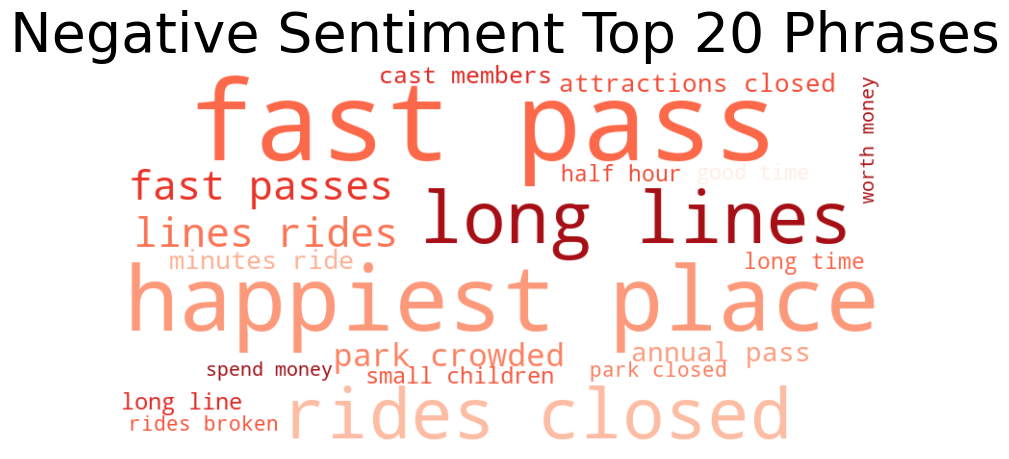

In [54]:
wordcloud = WordCloud(width=800, height=400, max_words = 20, relative_scaling = 1,
                      background_color='white', colormap = 'Reds').generate_from_frequencies(neg_phrase_freq)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Sentiment Top 20 Phrases', fontsize = 40)
plt.show()

# Topic Modelling with BERTopic & NetworkX

In [55]:
from pyvis.network import Network as net
from sklearn.metrics.pairwise import cosine_similarity
from bertopic import BERTopic
from bertopic.representation import MaximalMarginalRelevance
from sklearn.feature_extraction.text import CountVectorizer
import networkx as nx
from sentence_transformers import SentenceTransformer

In [56]:
pos_texts = pos_reviews['lemma'].astype(str).tolist()
neg_texts = neg_reviews['lemma'].astype(str).tolist()

In [57]:
vectorizer_model = CountVectorizer(ngram_range=(1, 3), stop_words ='english')
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
representation_model = MaximalMarginalRelevance(diversity=0.30)

model_pos = BERTopic(
    representation_model=representation_model, vectorizer_model=vectorizer_model,
    embedding_model=sentence_model,
    language = 'english', calculate_probabilities=True, verbose = True, 
    min_topic_size = 10, nr_topics="auto", top_n_words=5)

topics_pos, probs_pos = model_pos.fit_transform(pos_texts)

model_neg = BERTopic(
    representation_model=representation_model, vectorizer_model=vectorizer_model,
    embedding_model=sentence_model,
    language = 'english', calculate_probabilities=True, verbose = True, 
    min_topic_size = 8, nr_topics="auto", top_n_words=5)

topics_neg, probs_neg = model_neg.fit_transform(neg_texts)

2024-07-06 11:16:10,220 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/473 [00:00<?, ?it/s]

2024-07-06 11:16:20,407 - BERTopic - Embedding - Completed ✓
2024-07-06 11:16:20,407 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-07-06 11:16:34,650 - BERTopic - Dimensionality - Completed ✓
2024-07-06 11:16:34,650 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-07-06 11:16:35,312 - BERTopic - Cluster - Completed ✓
2024-07-06 11:16:35,313 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-07-06 11:16:37,603 - BERTopic - Representation - Completed ✓
2024-07-06 11:16:37,609 - BERTopic - Topic reduction - Reducing number of topics
2024-07-06 11:16:39,965 - BERTopic - Topic reduction - Reduced number of topics from 5 to 5
2024-07-06 11:16:40,071 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/27 [00:00<?, ?it/s]

2024-07-06 11:16:40,866 - BERTopic - Embedding - Completed ✓
2024-07-06 11:16:40,866 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-07-06 11:16:43,955 - BERTopic - Dimensionality - Completed ✓
2024-07-06 11:16:43,956 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-07-06 11:16:43,986 - BERTopic - Cluster - Completed ✓
2024-07-06 11:16:43,987 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-07-06 11:16:44,442 - BERTopic - Representation - Completed ✓
2024-07-06 11:16:44,443 - BERTopic - Topic reduction - Reducing number of topics
2024-07-06 11:16:44,754 - BERTopic - Topic reduction - Reduced number of topics from 15 to 11


In [58]:
model_pos.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,49,-1_christmas_holiday_park_halloween,"[christmas, holiday, park, halloween, disneyland]","[['like', 'firework', 'spectacular', 'holiday'..."
1,0,14545,0_park_disneyland_disney_place,"[park, disneyland, disney, place, fast pass]","[['Birnbaum', 'Disneyland', 'planning', 'guide..."
2,1,238,1_halloween_halloween party_trick treat_candy,"[halloween, halloween party, trick treat, cand...","[['love', 'DIsney', 'family', 'love', 'Disney'..."
3,2,218,2_christmas_holiday_disneyland_christmas decor...,"[christmas, holiday, disneyland, christmas dec...","[['open', 'close', 'long', 'truly', 'amazing',..."
4,3,86,3_christmas_park_holiday_disneyland,"[christmas, park, holiday, disneyland, decorat...","[['finally', 'bullet', 'book', 'stay', 'direct..."


In [59]:
model_neg.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,443,-1_park_disney_disneyland_hour,"[park, disney, disneyland, hour, crowd]","[['visit', 'Disneyland', 'August', 'shock', 'r..."
1,0,133,0_park_disneyland_disney_visit,"[park, disneyland, disney, visit, hour]","[['find', 'review', 'hard', 'write', 'year', '..."
2,1,94,1_park_disneyland_disney_ticket,"[park, disneyland, disney, ticket, say]","[['want', 'disneyland', 'birthdsay', 'Christma..."
3,2,64,2_park_line_minute_crowd,"[park, line, minute, crowd, ride break]","[['ride', 'close', 'maintenance', 'ride', 'shu..."
4,3,28,3_disney_ride_disneyland_little,"[disney, ride, disneyland, little, disneyworld]","[['Nightmare', 'Disneyland', 'ask', 'leave', '..."
5,4,19,4_fast pass_fastpass_minute_ticket,"[fast pass, fastpass, minute, ticket, park]","[['overcrowding', 'greed', 'basically', 'ruin'..."
6,5,14,5_disneyland_ride_spend_overprice,"[disneyland, ride, spend, overprice, waste money]","[['Disney', 'sucks', 'spend', 'wait', 'line', ..."
7,6,11,6_line_money_park_water,"[line, money, park, water, disneyland]","[['go', 'Disneyland', 'little', 'today', 'pric..."
8,7,10,7_commercialism_walt turn grave_dirty_happy pl...,"[commercialism, walt turn grave, dirty, happy ...","[['expensive', 'park', 'keep', 'dirty', 'Paper..."
9,8,10,8_disneyland_worth disneyland_orlando park_hotel,"[disneyland, worth disneyland, orlando park, h...","[['begin', 'bathroom', 'filthy', 'park', 'over..."


In [60]:
topic_embedding_pos = model_pos.topic_embeddings_
similarity_matrix_pos = cosine_similarity(topic_embedding_pos)

topic_embedding_neg = model_neg.topic_embeddings_
similarity_matrix_neg = cosine_similarity(topic_embedding_neg)

similarity_pos_df = pd.DataFrame(similarity_matrix_pos)
similarity_neg_df = pd.DataFrame(similarity_matrix_neg)

In [61]:
topic_keywords_pos = model_pos.get_topics()
topic_keywords_neg = model_neg.get_topics()

In [62]:
similarity_threshold = 0.5

In [63]:
G_pos = nx.Graph()
for topic_id in range(len(topics_pos)):
    if topic_id in topic_keywords_pos:
        topic_keywords_pos_str = ', '.join([word for word, _ in topic_keywords_pos[topic_id][:2]])
        G_pos.add_node(topic_id, label = topic_keywords_pos_str)
        
# Add nodes
for topic_id in range(len(topics_pos)):
    if topic_id in topic_keywords_pos:
        topic_keywords_pos_str = ', '.join([word for word, _ in topic_keywords_pos[topic_id][:2]])
        G_pos.add_node(topic_id, label=topic_keywords_pos_str)

# Add edges
num_topics = len(similarity_matrix_pos)
for i in range(num_topics):
    for j in range(i + 1, num_topics):
        if similarity_matrix_pos[i, j] > similarity_threshold:
            if i in G_pos.nodes and j in G_pos.nodes:
                G_pos.add_edge(i, j)
    
pyvis_graph = net(height='800px', width='100%', notebook=True)
pyvis_graph.from_nx(G_pos)
pyvis_graph.barnes_hut()
pyvis_graph.show_buttons()
pyvis_graph.show('Positive_Sentiment_Theme_Network.html')

Positive_Sentiment_Theme_Network.html


In [64]:
G_neg = nx.Graph()
for topic_id in range(len(topics_neg)):
    if topic_id in topic_keywords_neg:
        topic_keywords_neg_str = ', '.join([word for word, _ in topic_keywords_neg[topic_id][:2]])
        G_neg.add_node(topic_id, label = topic_keywords_neg_str)
        
# Add nodes
for topic_id in range(len(topics_neg)):
    if topic_id in topic_keywords_neg:
        topic_keywords_neg_str = ', '.join([word for word, _ in topic_keywords_neg[topic_id][:2]])
        G_neg.add_node(topic_id, label=topic_keywords_neg_str)

# Add edges
num_topics = len(similarity_matrix_neg)
for i in range(num_topics):
    for j in range(i + 1, num_topics):
        if similarity_matrix_neg[i, j] > similarity_threshold:
            if i in G_neg.nodes and j in G_neg.nodes:
                G_neg.add_edge(i, j)
    
pyvis_graph = net(height='800px', width='100%', notebook=True)
pyvis_graph.from_nx(G_neg)
pyvis_graph.barnes_hut()
pyvis_graph.show_buttons()
pyvis_graph.show('Negative_Sentiment_Theme_Network.html')

Negative_Sentiment_Theme_Network.html
